In [1]:
import random
import lightgbm as lgb
import pandas as pd
import string
import pickle

from utils import *
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from MultiLabelEncoder import MultiLabelEncoder

## Disable warnings

In [2]:
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

## Configure run parameters and Label encoder


In [3]:
TRANSACTION = ['customer_id', 'article_id', 'sales_channel_id', 'price', 't_dat']
ARTICLE = ['article_id', 'colour_group_code','product_code', 'product_type_name', 'department_no', 'prod_name', 'detail_desc','garment_group_no', 'product_type_no', 'section_no', 'index_group_no', 'index_code', 'graphical_appearance_no']
CUSTOMER = ['customer_id', 'age', 'postal_code']
SAMPLE = ['customer_id', 'article_id', 'age_in_weeks', 'product_code', 'season', 'material', 'price_cat','colour_group_code', 'department_no', 'garment_group_no', 'product_type_no', 'section_no', 'index_group_no', 'index_code', 'graphical_appearance_no', 'ordered']

RANKER_FIXED = {
    'objective': 'lambdarank',
    'metric': 'map',
    'boosting':'dart',
    'importance_type': "gain",
    'eval_at': 12,
    'n_jobs': 2
    }

RANKER_SEARCH = {
    'learning_rate': 0.0075,
    'depth': 15,
    'child': 20,
    'estimators': 200,
    'subsample': 0.1,
    'verbose': 0,
    'leaves': 20
    }

EVAL = False
LOAD_NEG_SAMPLES = False
GENERALIZE_MATERIALS = False



## Load data
Sadly as my memory is not infinite and I am too poor to spend money on the problem, the 5% dataset is the most I can work with.

In [4]:
articles = pd.read_csv('../data/articles_sample5.csv.gz')
customers = pd.read_csv('../data/customers.csv.gz')
transactions = pd.read_csv('../data/transactions_sample5.csv.gz')

# Preprocessing

## Creating label encoders
We require these to encode some attributes later on. Seemed nice to summarize them here :)

In [5]:
# create encoders
article_id_encoder = preprocessing.LabelEncoder()
customer_id_encoder = preprocessing.LabelEncoder()
index_code_encoder = preprocessing.LabelEncoder()
material_encoder = preprocessing.LabelEncoder()
age_cat_encoder = preprocessing.LabelEncoder()
season_encoder = preprocessing.LabelEncoder()
postal_code_encoder = preprocessing.LabelEncoder()


## Preprocess transactions
Some basic preprocessing. No new attributes/features are added here. 

In [6]:
# use selected attributes
transactions_processed = transactions[TRANSACTION].copy()

# Converting values of t_dat column to datetime format
transactions_processed['t_dat'] = pd.to_datetime(transactions_processed['t_dat'])

# fill na
transactions_processed = transactions_processed.fillna(0)

# encode customer_id
transactions_processed['article_id'] = article_id_encoder.fit_transform(transactions_processed['article_id'])
transactions_processed['customer_id'] = customer_id_encoder.fit_transform(transactions_processed['customer_id'])

# calculate age in weeks
transactions_processed = transactions_age_in_weeks(transactions_processed)

# Extracting week nr
transactions_processed['week_nr'] = transactions_processed['t_dat'].dt.isocalendar().week

# ordered
transactions_processed['ordered'] = 1

transactions = transactions_processed
del transactions_processed
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1589121 entries, 0 to 1589120
Data columns (total 8 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   customer_id       1589121 non-null  int64         
 1   article_id        1589121 non-null  int64         
 2   sales_channel_id  1589121 non-null  int64         
 3   price             1589121 non-null  float64       
 4   t_dat             1589121 non-null  datetime64[ns]
 5   age_in_weeks      1589121 non-null  int64         
 6   week_nr           1589121 non-null  UInt32        
 7   ordered           1589121 non-null  int64         
dtypes: UInt32(1), datetime64[ns](1), float64(1), int64(5)
memory usage: 92.4 MB


## Preprocess customers
Apart of basic preprocessing we also add two attributes.

In [7]:
# use selected attributes
customers_processed = customers[CUSTOMER].copy()

# encode customer id
customers_processed['customer_id'] = customer_id_encoder.fit_transform(customers_processed['customer_id'])
customers_processed['postal_code'] = postal_code_encoder.fit_transform(customers_processed['postal_code'])
customers_processed.head()

,customer_id,age,postal_code
0,0,49.0,112978
1,1,25.0,57312
2,2,24.0,139156
3,3,54.0,128529
4,4,52.0,52371


### Age category
This is a very simple idea. We merely intend on generalizing the age attribute by creating age categories (buckets) and sorting every customer into one. As you can see we filled the empty ages to age 20 as this is the most common age. We also chose to combine everyone above 66 as those buckets were becoming realy small.

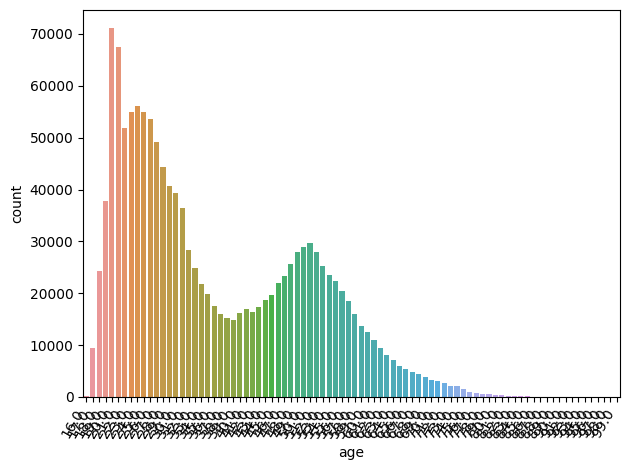

In [8]:
# fill unknown customer ages
customers_processed['age'] = customers_processed['age'].fillna(20)

# create barplot
age_count = customers_processed["age"].value_counts().rename_axis("age").reset_index(name="count")
age_count = age_count.sort_values(by="count", ascending=False)

ax = sns.barplot(age_count, x="age", y='count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
plt.tight_layout()
plt.show()

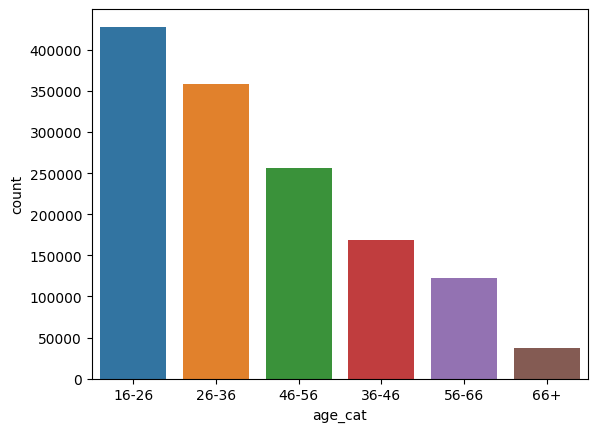

In [9]:
# bucket ages
customers_processed = bucket_ages(customers_processed)

# create barplot
age_count = customers_processed["age_cat"].value_counts().rename_axis("age_cat").reset_index(name="count")
age_count = age_count.sort_values(by="count", ascending=False)

sns.barplot(age_count, x="age_cat", y='count')
plt.show()

# encode
customers_processed['age_cat'] = age_cat_encoder.fit_transform(customers_processed['age_cat'])

In [10]:
customers_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   customer_id  1371980 non-null  int64  
 1   age          1371980 non-null  float64
 2   postal_code  1371980 non-null  int64  
 3   age_cat      1371980 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 41.9 MB


In [11]:
# extract relation between age and postal code

customers = customers_processed
del customers_processed
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   customer_id  1371980 non-null  int64  
 1   age          1371980 non-null  float64
 2   postal_code  1371980 non-null  int64  
 3   age_cat      1371980 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 41.9 MB


## Preprocess articles

In [12]:
# use selected attributes
articles_processed = articles[ARTICLE].copy()

# fill na
articles_processed['detail_desc'] = articles_processed['detail_desc'].fillna('None')
articles_processed = articles_processed.fillna(0)

# encoding index_code
articles_processed['index_code'] = index_code_encoder.fit_transform(articles_processed['index_code'])
articles_processed['article_id'] = article_id_encoder.fit_transform(articles_processed['article_id'])



# lowercasing detailed description
articles_processed['detail_desc'] = articles_processed['detail_desc'].str.lower()

# removing punctuation from detailed description
punct_chars = set(string.punctuation)
articles_processed['detail_desc'] = articles_processed['detail_desc'].apply(lambda x: ''.join(char for char in x if char not in punct_chars))


### Extracting materials
By taking the detailed description column of an article and scraping Wikipedia's 'list of fabrics', we can determine the fabric of the item. Some items have multiple materials in their description, but when looking at these description we see that the first mentioned material is the most important one (in most cases).

In [13]:
# extract materials 
articles_processed = extract_article_material(articles_processed)
articles_processed[articles_processed['material'] == 'chenille']
articles_processed['material'].info()


<class 'pandas.core.series.Series'>
RangeIndex: 77239 entries, 0 to 77238
Series name: material
Non-Null Count  Dtype 
--------------  ----- 
77239 non-null  object
dtypes: object(1)
memory usage: 603.6+ KB


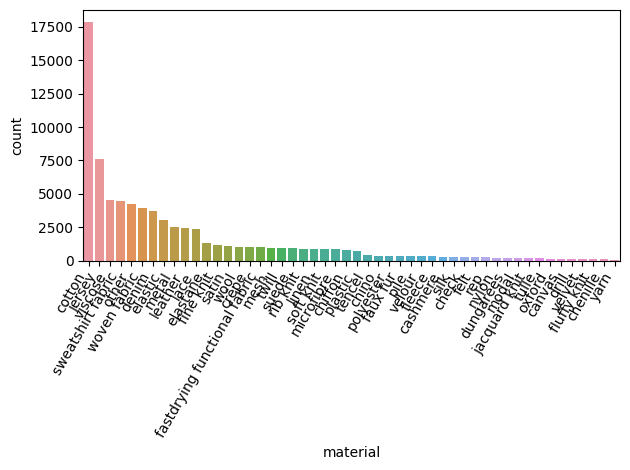

In [14]:
# create barplot
material_counts = articles_processed["material"].value_counts().rename_axis("material").reset_index(name="count")
material_counts = material_counts.sort_values(by="count", ascending=False).head(50)

ax = sns.barplot(material_counts, x="material", y='count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
plt.tight_layout()
plt.show()



As visible in the barplot above, not every material is as common as the other. Perhaps some generalization can benefit the ranker later on.

In [15]:
articles_processed['material'].value_counts()

cotton               17867
jersey                7608
viscose               4549
sweatshirt fabric     4454
other                 4242
                     ...  
chambray                 2
gingham                  1
rayon                    1
drago                    1
leatherette              1
Name: material, Length: 83, dtype: int64

Since a lot of names in this list refer to the usage of a specialized technique of handling certain base fabrics, it is hard to do proper generalization to these base fabrics. Thus we simply generalize uncommon names under the label 'other'. This probabily will lead the ranker sometimes making bad decisions, but it is the best we can do without hand-tailoring every fabric.

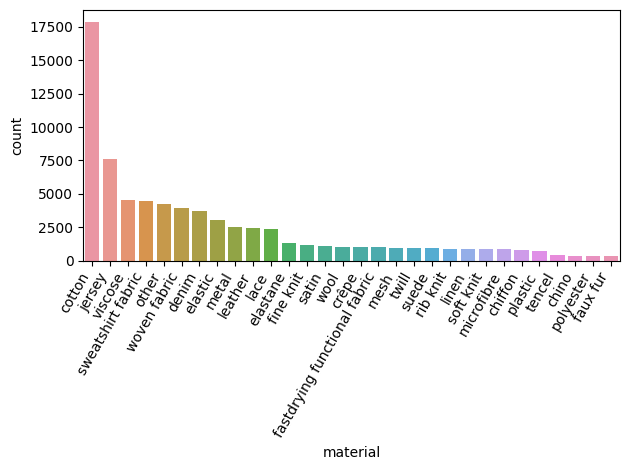

In [16]:
# generalize uncommon materials under a single label if enabled
if GENERALIZE_MATERIALS:
    counts = articles_processed['material'].value_counts()
    idx = counts[counts.lt(150)].index
    articles_processed.loc[articles_processed['material'].isin(idx), 'material'] = 'other'


# create barplot
material_counts = articles_processed["material"].value_counts().rename_axis("material").reset_index(name="count")
material_counts = material_counts.sort_values(by="count", ascending=False).head(30)
ax = sns.barplot(material_counts, x="material", y='count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
plt.tight_layout()
plt.show()



We see that a lot of articles are getting labeled under 'other'. This label concludes all items which either have no description or those where the description does not match any known material.
Firstly let's take a look at how many items lack a description and how many are simply not matched.

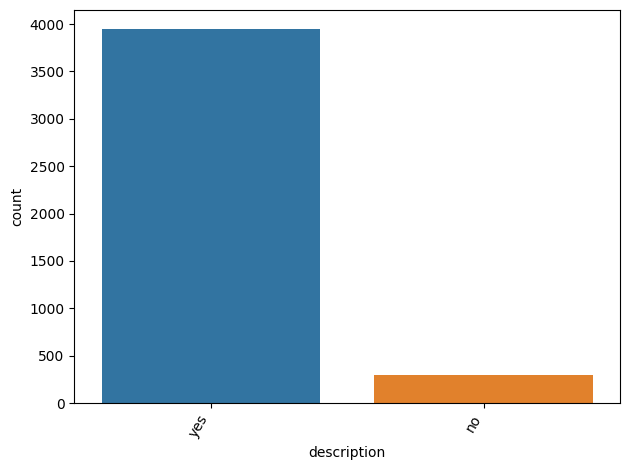

In [17]:
# collect articles with description and without one in seperate dataframes
no_desc = articles_processed[(articles_processed['material'] == 'other') & (articles_processed['detail_desc'] == 'none')].shape[0]
desc = articles_processed[(articles_processed['material'] == 'other') & (articles_processed['detail_desc'] != 'none')].shape[0]
d = {'description': ['yes', 'no'], 'count': [desc, no_desc]}
df = pd.DataFrame(data=d)

# plot
ax = sns.barplot(df, x="description", y='count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
plt.tight_layout()
plt.show()

 We see that there are more items not matching than there are without a description. This is good as this means we can improve.
 
Perhaps a deeper look into this class of unmatching items might enable us to differentiate a bit within this class. 

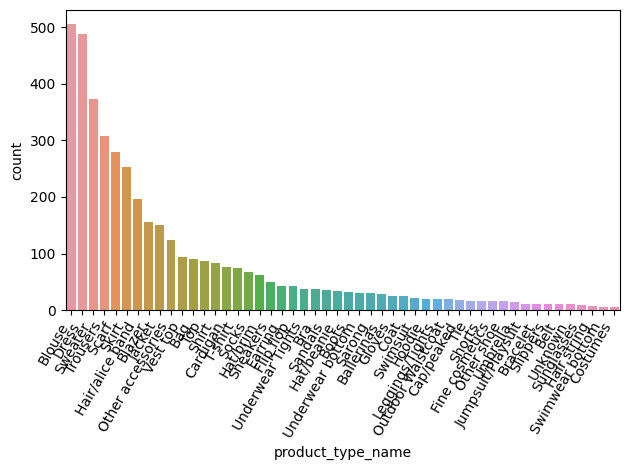

In [18]:
# collect all articles with material label 'other'
the_others = articles_processed[articles_processed['material'] == 'other'].drop_duplicates()

# create barplot of categories
cat_count = the_others["product_type_name"].value_counts().rename_axis("product_type_name").reset_index(name="count")
cat_count = cat_count.sort_values(by="count", ascending=False).head(50)
ax = sns.barplot(cat_count, x="product_type_name", y='count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
plt.tight_layout()
plt.show()

We see that the problem is for most part spread among many different product types. The fabrics used in sweaters appear to be uncommon knowledge. Perhaps looking at the detailed description might deliver us a new fabric.

In [19]:
# print out some descriptions to find missing materials
sweaters = the_others[the_others['product_type_name'] == 'Leggings/Tights'][['detail_desc']].drop_duplicates().values
print(sweaters)

[['tights with builtin support to lift the bottom black in 30 denier and light amber in 15 denier']
 ['50 denier tights with reinforcement at the top for a shaping effect on the tummy and thighs']
 ['highwaisted tights that lift the bum and shape the waist and thighs 30 denier']
 ['matt opaque tights with a control top to hold in the tummy and bum 100 denier']
 ['leggings with extra space for a growing tummy 200 denier']
 ['controltop tights that shape the tummy and bum 30 denier']
 ['none']
 ['fineknit leggings with a soft brushed finish wide ribbing at the waist for best fit']
 ['anklelength cigarette trousers in a stretch weave with a regular waist concealed zip in one side fake back pockets and tapered legs with slits at the hems']
 ['studio collection leggings in sturdy jacquardpatterned seamless fabric high waist with a ribbed waistband']
 ['footless tights with stirrups']
 ['ribbed leggings designed with the minimum number of seams for a more comfortable fit and increased mobili

Now that we have extracted the materials, it might be interesting to see if there is a relation present between the price of an article and the related material.

### Extracting season
By checking in which months an item is most desired we can draw conclusion around the season it is most probabily related to. 

In [20]:
# extract season
articles_processed = extract_season(transactions, articles_processed)


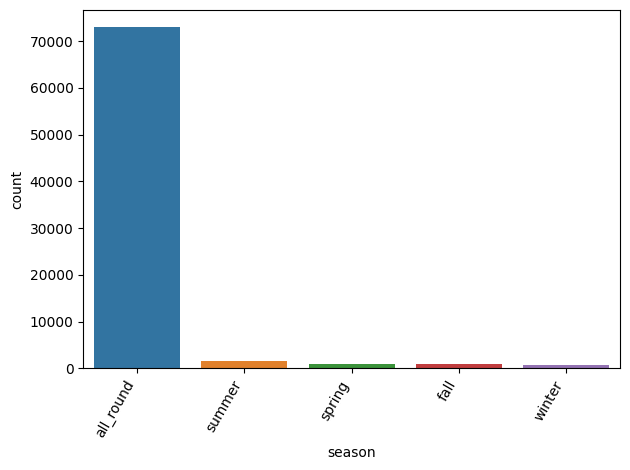

In [21]:
# plot seasons
season_counts = articles_processed["season"].value_counts().rename_axis("season").reset_index(name="count")
season_counts = season_counts.sort_values(by="count", ascending=False)
ax = sns.barplot(season_counts, x="season", y='count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
plt.tight_layout()
plt.show()

In [22]:
# encode season
articles_processed['season'] = season_encoder.fit_transform(articles_processed['season'])

### Extracting article price and price category
By using the transaction histories of items we can derive a price category to which it belongs. If we take the lowest transaction price in which an item occurs, we can derive that this is probabily the actual price of the article. Naturaly this method is naive as we do not know whether or not sales are included. Thus some verification to check the correctness of this idea is required.

In [23]:
prices = transactions[["article_id", "price"]].groupby(["article_id"]).min("price")

# Min-Max scale the price to provide more clear boundaries
prices['old_price'] = prices['price']
prices['price'] = (prices['price'] - prices['price'].min()) / prices['price'].max() - prices['price'].min()
articles_processed = articles_processed.merge(prices, on=["article_id"], how="inner")

articles_processed.head()

,article_id,colour_group_code,product_code,product_type_name,department_no,prod_name,detail_desc,garment_group_no,product_type_no,section_no,index_group_no,index_code,graphical_appearance_no,material,total,season,price,old_price
0,0,9,108775,Vest top,1676,Strap top,jersey top with narrow shoulder straps,1002,253,16,1,0,1010016,jersey,577.0,1,0.004717,0.002525
1,1,10,108775,Vest top,1676,Strap top,jersey top with narrow shoulder straps,1002,253,16,1,0,1010016,jersey,405.0,2,0.006420,0.003373
2,2,11,108775,Vest top,1676,Strap top (1),jersey top with narrow shoulder straps,1002,253,16,1,0,1010017,jersey,0.0,0,0.007782,0.004051
3,3,9,110065,Bra,1339,OP T-shirt (Idro),microfibre tshirt bra with underwired moulded ...,1017,306,61,1,1,1010016,microfibre,53.0,1,0.012243,0.006271
4,4,10,110065,Bra,1339,OP T-shirt (Idro),microfibre tshirt bra with underwired moulded ...,1017,306,61,1,1,1010016,microfibre,34.0,0,0.009552,0.004932


In [24]:
# check if all articles have a price
print(articles_processed['price'].isna().sum)

<bound method NDFrame._add_numeric_operations.<locals>.sum of 0        False
1        False
2        False
3        False
4        False
         ...  
77234    False
77235    False
77236    False
77237    False
77238    False
Name: price, Length: 77239, dtype: bool>


After applying min-max scaling to scale the data points between 0 and 1 (cleaner scale), we can set up boundaries for the different price classes. Let's say that every item before the end of the initial peak is labeled 'cheap', following that we have 'normal' until 0.4. Then follows 'affordable' until 0.6 and lastly we have 'expensive' for eveything past that point.


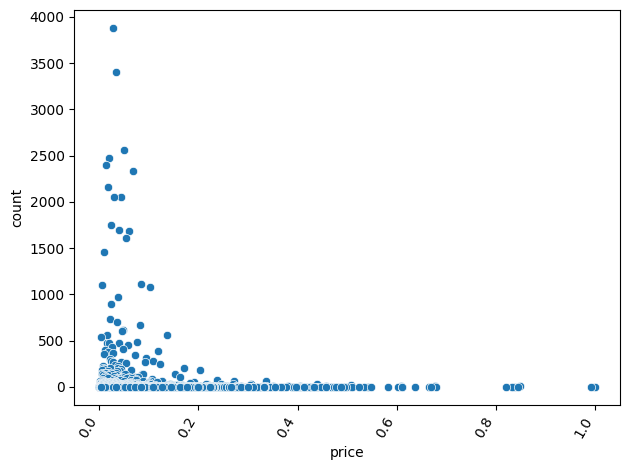

In [25]:
# plot scaled prices
price_counts = articles_processed["price"].value_counts().rename_axis("price").reset_index(name="count")
price_counts = price_counts.sort_values(by="count", ascending=False)
ax = sns.scatterplot(price_counts, x="price", y='count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
plt.tight_layout()
plt.show()

### Recognizing big sales
Every winter and summer a big sale occurs in most stores. If this sale is present within the data it means that our price extraction method is inaccurate as taking the minimum sold price of an item can relate back to one of these big sales. If we calculate the avergage weekly income and plot this using a scatterplot we should get an idea.

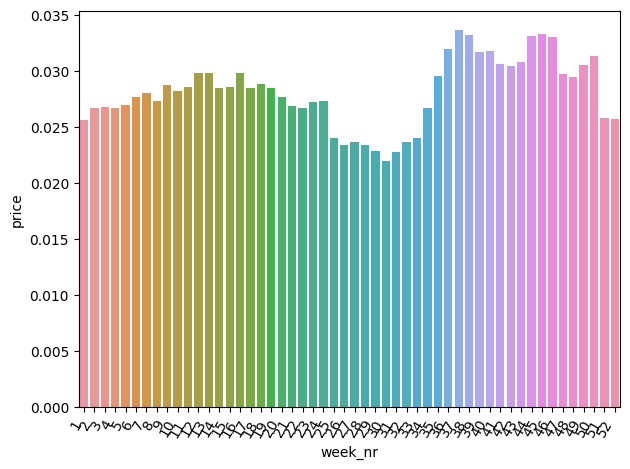

In [26]:
weekly_averages = transactions.groupby(by=['week_nr'])['price'].mean().reset_index()
ax = sns.barplot(weekly_averages, x="week_nr", y='price')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
plt.tight_layout()
plt.show()

These large sales are most commonly in the months July (ca 26-31) and January (ca 0-5).  The summer sale can be recognized with ease as the large drop in the middle of the graph. The January sale is also present, but less obvious than the summer sale. This means that our price estimation is not always correct, we thus have to improve our method.

### Improving the price extraction
We believe that our idea of taking the minimum price of a the transactions in which an article is present in order to find the most accurate article price is a good approach. But perhaps we should select a period, excluding the sales, in which we look for prices.

In [27]:
# filter out sale weeks and collect prices
exclusion_period = [1, 2, 3, 4, 5, 6, 26, 27, 28, 29, 30, 31, 32, 33, 34, 51, 52]
filter_period = transactions[~transactions['week_nr'].isin(exclusion_period)]
prices = filter_period[["article_id", "price"]].groupby(["article_id"]).min("price")

# min-max scaling
prices['price'] = (prices['price'] - prices['price'].min()) / prices['price'].max() - prices['price'].min()
prices.rename(columns={'price': 'new_price'}, inplace=True)

# merge with articles
articles_processed = articles_processed.merge(prices, on=["article_id"], how="inner")
articles_processed.head()


,article_id,colour_group_code,product_code,product_type_name,department_no,prod_name,detail_desc,garment_group_no,product_type_no,section_no,index_group_no,index_code,graphical_appearance_no,material,total,season,price,old_price,new_price
0,0,9,108775,Vest top,1676,Strap top,jersey top with narrow shoulder straps,1002,253,16,1,0,1010016,jersey,577.0,1,0.004717,0.002525,0.004899
1,1,10,108775,Vest top,1676,Strap top,jersey top with narrow shoulder straps,1002,253,16,1,0,1010016,jersey,405.0,2,0.006420,0.003373,0.010923
2,2,11,108775,Vest top,1676,Strap top (1),jersey top with narrow shoulder straps,1002,253,16,1,0,1010017,jersey,0.0,0,0.007782,0.004051,0.008513
3,3,9,110065,Bra,1339,OP T-shirt (Idro),microfibre tshirt bra with underwired moulded ...,1017,306,61,1,1,1010016,microfibre,53.0,1,0.012243,0.006271,0.021365
4,4,10,110065,Bra,1339,OP T-shirt (Idro),microfibre tshirt bra with underwired moulded ...,1017,306,61,1,1,1010016,microfibre,34.0,0,0.009552,0.004932,0.027268


In [28]:
# check if all articles have a price
print(articles_processed['price'].isna().sum)

<bound method NDFrame._add_numeric_operations.<locals>.sum of 0        False
1        False
2        False
3        False
4        False
         ...  
71102    False
71103    False
71104    False
71105    False
71106    False
Name: price, Length: 71107, dtype: bool>


When we plot out the new prices against the previous version of prices we end up with the following

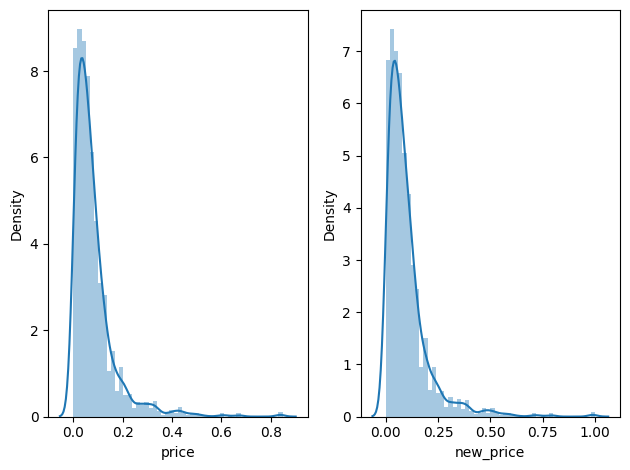

In [29]:
# plot distribution graphs
fig, ax =plt.subplots(1,2)

price_counts = articles_processed["price"].value_counts().rename_axis("price").reset_index(name="count")
price_counts = price_counts.sort_values(by="count", ascending=False)

sns.distplot(price_counts['price'], ax=ax[0])
price_counts = articles_processed["new_price"].value_counts().rename_axis("new_price").reset_index(name="count")
price_counts = price_counts.sort_values(by="count", ascending=False)
sns.distplot(price_counts['new_price'], ax=ax[1])

plt.tight_layout()
plt.show()

We generally notice a very slight shift towards higher prices. The density at most price points is also much lower compared to the previous approach. This indicates that there were indeed articles being sold at a lower price during the sales.

In [30]:
# drop unused columns of old prices
articles_processed.drop(columns=['price', 'old_price'], inplace=True)
articles_processed.rename(columns={'new_price': 'price'}, inplace=True)

In [31]:
# extract price category
articles_processed = extract_price_category(transactions, articles_processed)

### Material prices
Now that we have both the price of individual items and their main material, perhaps it is of interest to verify the average price of materials. Since some materials are more common than others and outliers might be present, we will be using the mean as reference. If this result matches our expectations, it helps to further prove the correctness of both the material and price extractor.

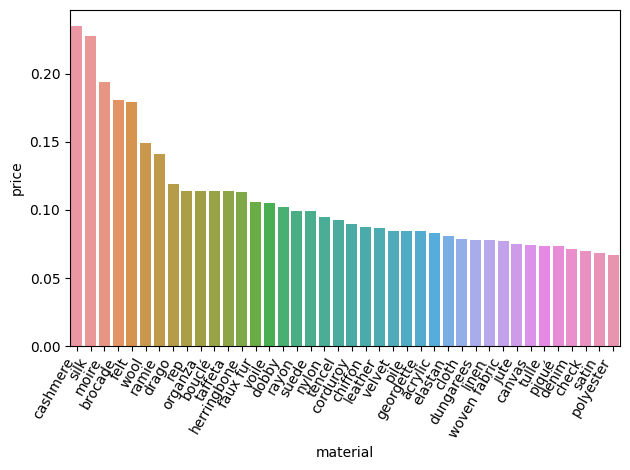

In [32]:
average_material_prices = articles_processed.groupby(['material'])['price'].mean().reset_index(name="price")
average_material_prices = average_material_prices.sort_values(by='price', ascending=False).head(40)
ax = sns.barplot(average_material_prices, x="material", y='price')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
plt.tight_layout()
plt.show()

As expected, the more luxurious materials are the more expensive ones. This means that our material extractor is in fact working as intended. 
 There are still some odd balls present in this list. On such example is that leather is listed to be generally less expensive than wool. This makes little sense initially, but considering the fact that leather is often used in smaller, cheaper products, such as belts, this can be explained. Below are some numbers to verify this hypothesis.

In [33]:
leather_items = articles_processed[articles_processed['material'] == 'leather'][['article_id', 'prod_name','price']]
leather_items['price'].describe()

count    2233.000000
mean        0.086469
std         0.099182
min         0.000441
25%         0.039839
50%         0.063132
75%         0.099276
max         0.998915
Name: price, dtype: float64

In [34]:
wool_items = articles_processed[articles_processed['material'] == 'wool'][['article_id', 'prod_name','price']]
wool_items['price'].describe()

count    948.000000
mean       0.148805
std        0.126240
min        0.001284
25%        0.056907
50%        0.119357
75%        0.197529
max        0.798915
Name: price, dtype: float64

Leather is more frequent than wool and has a higher maximal price, but wool has a smaller deviation and higher mean.

In [35]:
# drop price attribute
articles_processed.drop(columns=['price'], inplace=True)
# encode material
articles_processed['material'] = material_encoder.fit_transform(articles_processed['material'])

# encode price categroy
articles_processed['price_cat'] = season_encoder.fit_transform(articles_processed['price_cat'])

articles = articles_processed
del articles_processed
articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71107 entries, 0 to 71106
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   article_id               71107 non-null  int64  
 1   colour_group_code        71107 non-null  int64  
 2   product_code             71107 non-null  int64  
 3   product_type_name        71107 non-null  object 
 4   department_no            71107 non-null  int64  
 5   prod_name                71107 non-null  object 
 6   detail_desc              71107 non-null  object 
 7   garment_group_no         71107 non-null  int64  
 8   product_type_no          71107 non-null  int64  
 9   section_no               71107 non-null  int64  
 10  index_group_no           71107 non-null  int64  
 11  index_code               71107 non-null  int64  
 12  graphical_appearance_no  71107 non-null  int64  
 13  material                 71107 non-null  int64  
 14  total                 

## Personalized Negative sampling
We require negative samples as the data naturaly only reports sales. The initial approach was via random sampling but since this is a naive and random approach an improvement was required. We opted for a method that creates negative samples for individual persons based on their most recent purchases. The idea behind this is that when a customer buys an item A, we created negative samples for some items that are of similar type, color and material. We do this with the intention to create negative samples of items that the customer probabily does not like as he/she bought item A instead of similar items B, C, etc...

In [36]:
# set sampling parameters
samples_per_item = 3        # n
most_recent_item_count = 10  # m
transactions.drop(columns=['week_nr', 'age_in_weeks'], inplace=True)
transactions.head()

,customer_id,article_id,sales_channel_id,price,t_dat,ordered
0,31,28524,2,0.008458,2018-09-20,1
1,31,2616,2,0.022017,2018-09-20,1
2,31,2616,2,0.022017,2018-09-20,1
3,65,26235,1,0.042356,2018-09-20,1
4,208,30347,1,0.059305,2018-09-20,1


In [37]:

# merge with articles (required for neg sampling process)
samples = transactions.merge(articles, how="inner", on='article_id')
# create neg samples
neg_samples = advanced_neg_sampling(samples, articles, sample_count=samples_per_item, nr_most_recent=most_recent_item_count)
# concat positive and negative samples
samples = pd.concat([samples, neg_samples])
# merge with other data
samples = samples.merge(customers, how="inner", on='customer_id')
samples = samples.astype({'article_id': 'int', 'customer_id': 'int', 'ordered': 'int', 'age': 'int', 'sales_channel_id': 'int'})
samples.head()

10000/1574147
20000/1574147
30000/1574147
40000/1574147
50000/1574147
60000/1574147
70000/1574147
80000/1574147
90000/1574147
110000/1574147
120000/1574147
130000/1574147
140000/1574147
150000/1574147
160000/1574147
170000/1574147
180000/1574147
190000/1574147
210000/1574147
220000/1574147
230000/1574147
240000/1574147
250000/1574147
260000/1574147
270000/1574147
280000/1574147
290000/1574147
310000/1574147
320000/1574147
330000/1574147
340000/1574147
350000/1574147
360000/1574147
370000/1574147
380000/1574147
390000/1574147
410000/1574147
420000/1574147
430000/1574147
440000/1574147
450000/1574147
460000/1574147
470000/1574147
480000/1574147
490000/1574147
510000/1574147
520000/1574147
530000/1574147
540000/1574147
550000/1574147
560000/1574147
570000/1574147
580000/1574147
590000/1574147
610000/1574147
620000/1574147
630000/1574147
640000/1574147
650000/1574147
660000/1574147
670000/1574147
680000/1574147
690000/1574147
710000/1574147
720000/1574147
730000/1574147
740000/1574147
7500

,customer_id,article_id,sales_channel_id,price,t_dat,ordered,colour_group_code,product_code,product_type_name,department_no,...,index_group_no,index_code,graphical_appearance_no,material,total,season,price_cat,age,postal_code,age_cat
0,31,28524,2,0.008458,2018-09-20,1,51,673531,Other accessories,4313,...,4,8,1010016,46,0.0,0,1,68,247330,5
1,31,2616,2,0.022017,2018-09-20,1,8,464277,Underwear bottom,1334,...,1,1,1010016,14,105.0,0,1,68,247330,5
2,31,2616,2,0.022017,2018-09-20,1,8,464277,Underwear bottom,1334,...,1,1,1010016,14,105.0,0,1,68,247330,5
3,31,2616,2,0.019814,2019-04-24,1,8,464277,Underwear bottom,1334,...,1,1,1010016,14,105.0,0,1,68,247330,5
4,31,2616,2,0.017610,2019-09-28,1,8,464277,Underwear bottom,1334,...,1,1,1010016,14,105.0,0,1,68,247330,5


In [38]:
# check the ratio of negative to positive samples
print(samples['ordered'].value_counts())

0    3106035
1    1574147
Name: ordered, dtype: int64


## Preprocess samples

In [39]:
# Extracting age in weeks
samples = transactions_age_in_weeks(samples)


# remove unused columns
samples = samples[SAMPLE]
samples.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4680182 entries, 0 to 4680181
Data columns (total 16 columns):
 #   Column                   Dtype
---  ------                   -----
 0   customer_id              int64
 1   article_id               int64
 2   age_in_weeks             int64
 3   product_code             int64
 4   season                   int64
 5   material                 int64
 6   price_cat                int64
 7   colour_group_code        int64
 8   department_no            int64
 9   garment_group_no         int64
 10  product_type_no          int64
 11  section_no               int64
 12  index_group_no           int64
 13  index_code               int64
 14  graphical_appearance_no  int64
 15  ordered                  int64
dtypes: int64(16)
memory usage: 607.0 MB


# Generate candidates

## Popularity basis
Generate candidates based on popularity within the last 3 months.


In [40]:
# find the top 200 most popular items
n_popular_items = 50
recent_transactions = samples[(samples['age_in_weeks'] <= 12) & (samples['ordered'] == 1)]

popular_items = recent_transactions["article_id"].value_counts().reset_index(name="count").sort_values(by="count", ascending=False).head(n_popular_items)
popular_items.rename(columns={"index": "article_id"}, inplace=True)
popular_items.drop(columns=['count'], inplace=True)

unique_transactions = pd.merge(popular_items, recent_transactions, on='article_id').drop(columns=['customer_id']).drop_duplicates()
active_customers = recent_transactions.groupby(["age_in_weeks", "customer_id"]).head(1)[['customer_id', 'age_in_weeks']]

popularity_candidates = pd.merge(active_customers, unique_transactions, on='age_in_weeks').drop_duplicates()
popularity_candidates.head()


,customer_id,age_in_weeks,article_id,product_code,season,material,price_cat,colour_group_code,department_no,garment_group_no,product_type_no,section_no,index_group_no,index_code,graphical_appearance_no,ordered
0,59111,8,48701,751471,3,24,1,9,1722,1009,272,15,1,0,1010016,1
1,59111,8,37654,706016,0,17,1,9,1747,1009,272,53,2,3,1010016,1
2,59111,8,2185,448509,0,17,1,72,1747,1009,272,53,2,3,1010016,1
3,59111,8,70520,866383,0,46,1,9,4242,1018,298,60,1,1,1010016,1
4,59111,8,15239,610776,2,39,1,9,1676,1002,255,16,1,0,1010016,1


In [41]:
popularity_candidates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2367111 entries, 0 to 2367110
Data columns (total 16 columns):
 #   Column                   Dtype
---  ------                   -----
 0   customer_id              int64
 1   age_in_weeks             int64
 2   article_id               int64
 3   product_code             int64
 4   season                   int64
 5   material                 int64
 6   price_cat                int64
 7   colour_group_code        int64
 8   department_no            int64
 9   garment_group_no         int64
 10  product_type_no          int64
 11  section_no               int64
 12  index_group_no           int64
 13  index_code               int64
 14  graphical_appearance_no  int64
 15  ordered                  int64
dtypes: int64(16)
memory usage: 307.0 MB


# Ranking

## Combine data

In [42]:
data = pd.concat([samples, popularity_candidates])
del transactions
del customers
del articles
data[data['ordered'] == 0].head()

,customer_id,article_id,age_in_weeks,product_code,season,material,price_cat,colour_group_code,department_no,garment_group_no,product_type_no,section_no,index_group_no,index_code,graphical_appearance_no,ordered
30,31,41471,35,719957,0,14,1,8,1334,1017,286,61,1,1,1010010,0
31,31,41471,1,719957,0,14,1,8,1334,1017,286,61,1,1,1010010,0
32,31,5952,83,533925,0,46,1,51,3419,1019,78,66,1,2,1010016,0
33,31,70589,38,866657,0,14,1,8,1339,1017,286,61,1,1,1010010,0
34,31,1183,93,368979,4,39,1,9,1919,1005,273,2,1,0,1010016,0


## Split data

In [43]:
training_data = data[data['age_in_weeks'] != 0]
validation_data = data[data['age_in_weeks'] == 0]
training_data.dtypes


customer_id                int64
article_id                 int64
age_in_weeks               int64
product_code               int64
season                     int64
material                   int64
price_cat                  int64
colour_group_code          int64
department_no              int64
garment_group_no           int64
product_type_no            int64
section_no                 int64
index_group_no             int64
index_code                 int64
graphical_appearance_no    int64
ordered                    int64
dtype: object

In [44]:
# split train set
qids_train = training_data.groupby(["age_in_weeks", "customer_id"])["article_id"].count().values
training_data = training_data.drop(["age_in_weeks"], axis=1)
x_train = training_data.drop(columns=["ordered", "customer_id"])
y_train = training_data["ordered"]

# split validation set
qids_validation = validation_data.groupby(["age_in_weeks", "customer_id"])["article_id"].count().values
validation_data = validation_data.drop(["age_in_weeks"], axis=1)
x_test = validation_data.drop(columns=["ordered", "customer_id"])
y_test = validation_data["ordered"]



## Train ranker

In [ ]:
ranker = lgb.LGBMRanker(
    objective=RANKER_FIXED["objective"],
    metric=RANKER_FIXED["metric"],
    boosting_type=RANKER_FIXED["boosting"],
    importance_type=RANKER_FIXED["importance_type"],
    n_jobs=RANKER_FIXED["n_jobs"],
    n_estimators=RANKER_SEARCH["estimators"],
    verbose=RANKER_SEARCH["verbose"],
    min_child_samples=RANKER_SEARCH["child"],
    max_depth=RANKER_SEARCH["depth"],
    learning_rate=RANKER_SEARCH["learning_rate"],
    subsample=RANKER_SEARCH["subsample"],
    num_leaves=RANKER_SEARCH["leaves"],
    force_col_wise=True

)
# if eval parameter is true, evaluation will take place
if EVAL:
    ranker.fit(
        X=x_train,
        y=y_train,
        group=qids_train,
        eval_set=[(x_train, y_train),(x_test, y_test)],
        eval_group=[qids_train,qids_validation],
        eval_names=["training set","validation set"],
        eval_at=12,

    )
    lgb.plot_metric(ranker)
    plt.show()
else:
    ranker.fit(
        X=x_train,
        y=y_train,
        group=qids_train,
    )
    
# print feature importances
for i in ranker.feature_importances_.argsort()[::-1]:
    print(ranker.feature_name_[i], ranker.feature_importances_[i] / ranker.feature_importances_.sum())

## Predict top 12

In [ ]:
# predict
validation_data["prediction"] = ranker.predict(x_test)
validation_data.head()

In [ ]:
# decode article and customer ids
popular_items['article_id'] = article_id_encoder.inverse_transform(popular_items['article_id'])
validation_data['article_id'] = article_id_encoder.inverse_transform(validation_data['article_id'])
validation_data['customer_id'] = customer_id_encoder.inverse_transform(validation_data['customer_id'])


# group predictions per customer
predictions_for_customer = validation_data.sort_values(['customer_id', 'prediction'], ascending=False).groupby('customer_id')['article_id'].apply(list).to_dict()


# retrieve top 12
popular_12 = list(popular_items["article_id"].head(12))


In [ ]:
print(predictions_for_customer)

## Store predictions

In [ ]:
# load submission example
submission = pd.read_csv('../data/sample_submission.csv')

# encode customer_id's to allow matching
predictions = []

for customer_id in submission["customer_id"]:
    prediction = predictions_for_customer.get(customer_id, [])  # retrieve all predictions for given customer

    prediction = prediction + popular_12    # fill up predictions with popular_12
    predictions.append(prediction[:12]) # take 12 first items  
    
# parse to string format
predictions = [' '.join(['0' + str(p) for p in ps]) for ps in predictions]
submission["prediction"] = predictions

# store submission
submission.to_csv(f'../output/submission.csv.gz', index=False)
submission.head(20)